In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [2]:
# Load Data
steel_dat = pd.read_csv('mt_steel.csv')

steel_dat.info()
steel_dat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXPORT  44 non-null     float64
 1   YEAR    44 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 836.0 bytes


,EXPORT,YEAR
0,3.89,1937
1,2.41,1938
2,2.80,1939
3,8.72,1940
4,7.12,1941


In [3]:
# :)
print(steel_dat.isna().value_counts())

EXPORT  YEAR 
False   False    44
Name: count, dtype: int64


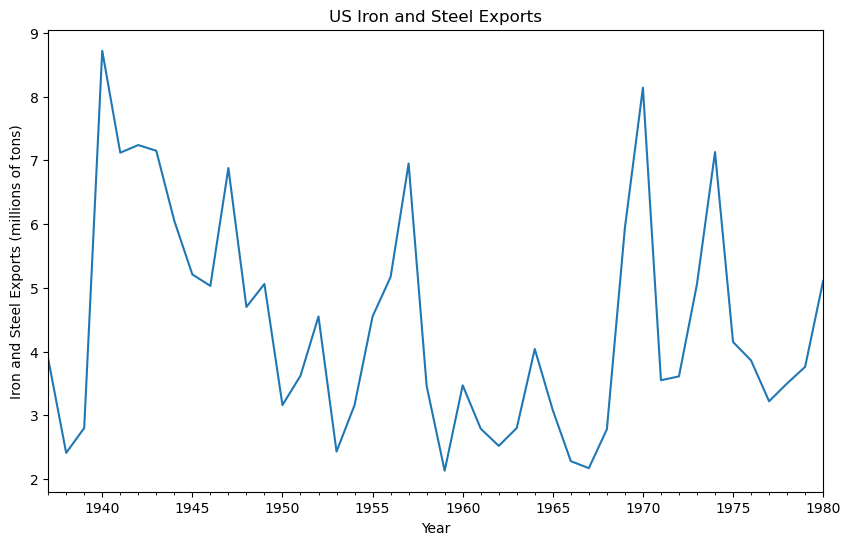

In [4]:
# Convert date column to a date class variable

steel_dat['YEAR'] = pd.to_datetime(steel_dat['YEAR'], format="%Y")

# Create indexed series


steel_ts = pd.Series(steel_dat['EXPORT'].values, index=steel_dat['YEAR'])


#Plot the series
plt.figure(figsize=(10, 6))
steel_ts.plot()
plt.title("US Iron and Steel Exports")
plt.xlabel("Year")
plt.ylabel("Iron and Steel Exports (millions of tons)")
plt.show()

In [5]:
#execute the Ljung Box test on the Steel series using 5 lags
EXPORTS = steel_dat[['EXPORT']]
sm.stats.acorr_ljungbox(EXPORTS, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,12.151048,0.032776


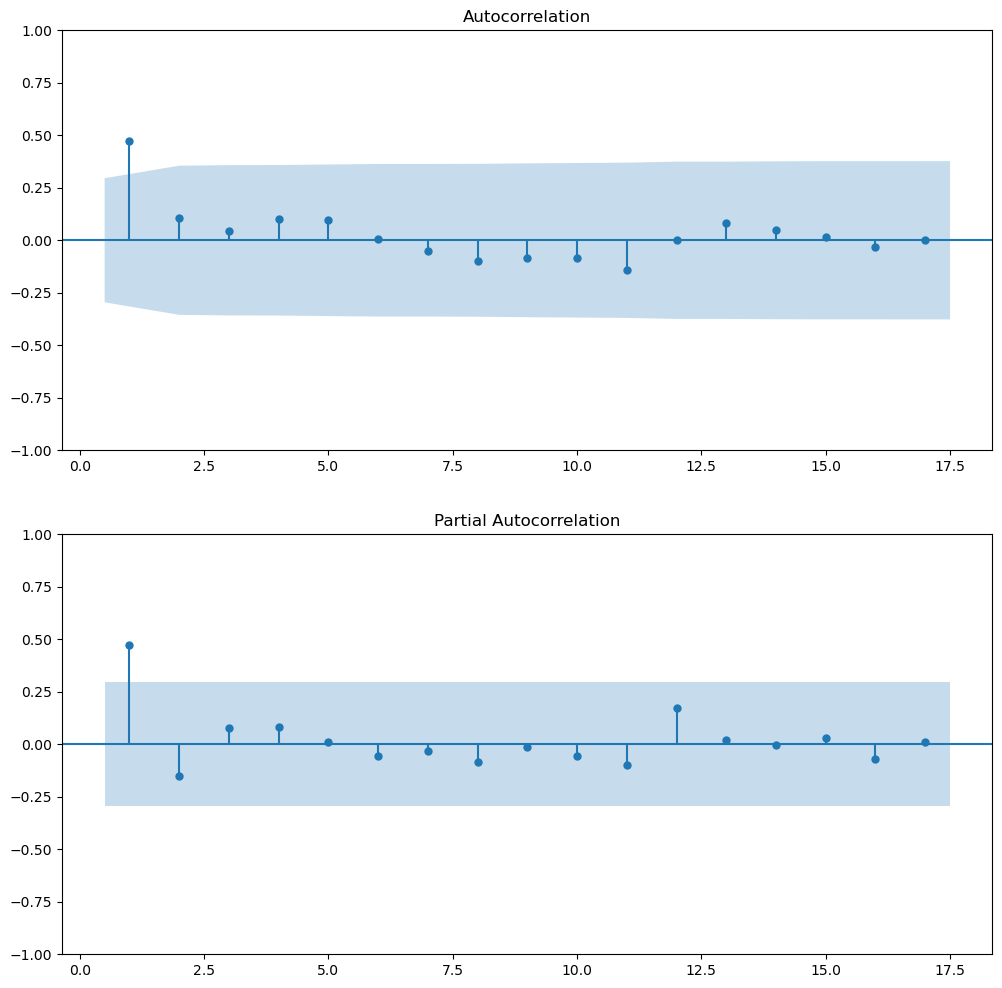

In [6]:
#Plot the ACF and PACF for the Steel series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(steel_ts, ax=ax1, zero=False)
plot_pacf(steel_ts, ax=ax2, zero=False)
plt.show()

This adfuller test determines that the time series is stationary since the adfuller p-value (0.002) is less than 0.05. We do not have to take a first difference and can move on.

In [7]:
adfuller(steel_ts, regression='c')

(-3.837652178900703,
 0.00254474237765945,
 1,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 116.78753840925027)

## Model 1

For my first model, I decided to have p = 1, d = 0, and q = 0. I did this because the first lag ACF spike is positive, and there is only one significant PACF spike.

In [8]:
model_1 = ARIMA(steel_ts, order=(1,0,0)).fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -81.186
Date:                Wed, 09 Oct 2024   AIC                            168.371
Time:                        15:17:35   BIC                            173.724
Sample:                    01-01-1937   HQIC                           170.356
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4213      0.554      7.975      0.000       3.335       5.508
ar.L1          0.4642      0.159      2.919      0.004       0.152       0.776
sigma2         2.3323      0.577      4.044      0.0

c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Here is a plot of the residuals for my first model.

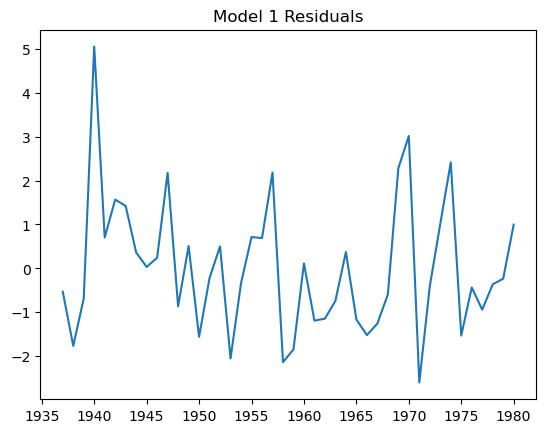

In [9]:
residuals = model_1.resid

plt.plot(residuals)
plt.title('Model 1 Residuals')
plt.show()

Here is the ACF and PACF graphs for my first model. They do not have any standout significant values which is good.

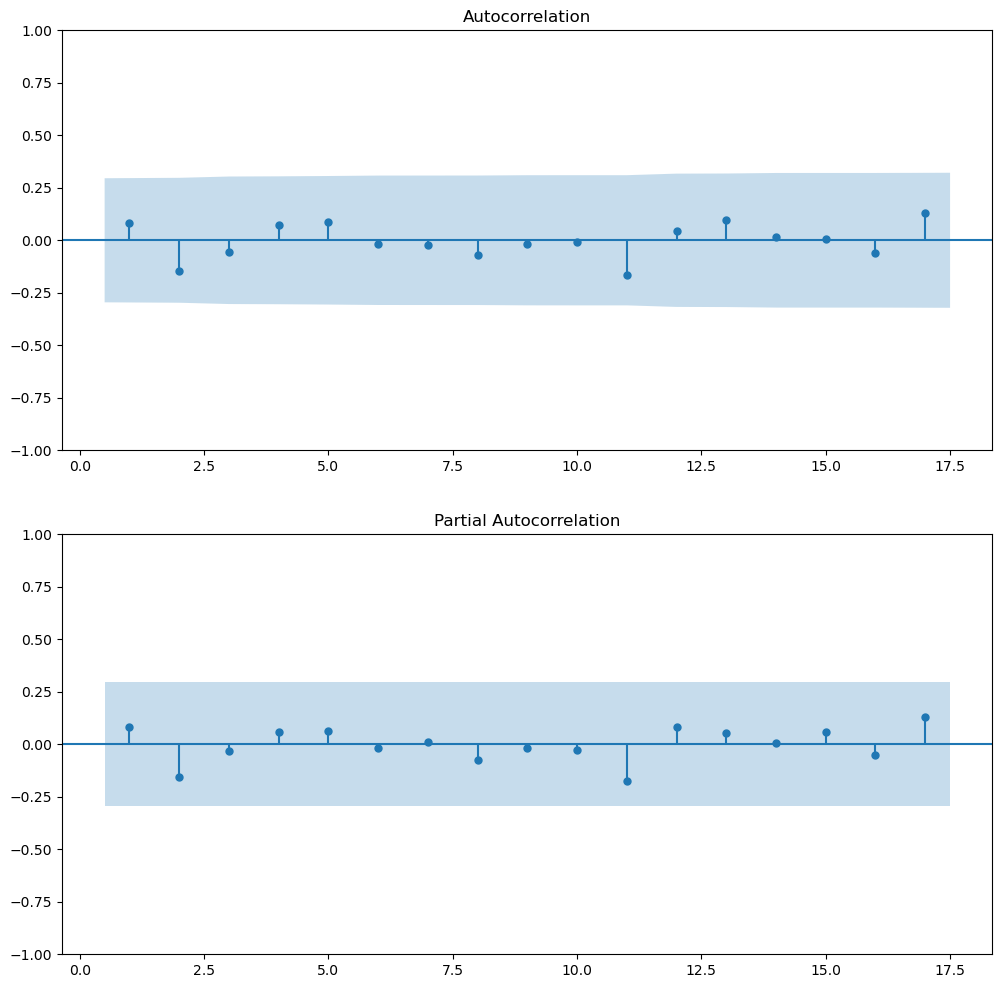

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False)
plt.show()

The Lj box test for the residuals shows me that the residuals are white noise since the ljbox p-value (0.99) is greater than 0.05.

In [11]:
sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.509502,0.990737


## Model 2

For the second model, I chose to increment the p value by 1, so my order would be p = 2, d = 0, and q = 0. I want to see how this model compares to the first model.

In [12]:
model_2 = ARIMA(steel_ts, order=(2,0,0)).fit()

print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -80.675
Date:                Wed, 09 Oct 2024   AIC                            169.351
Time:                        15:17:36   BIC                            176.488
Sample:                    01-01-1937   HQIC                           171.997
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4351      0.484      9.165      0.000       3.487       5.384
ar.L1          0.5369      0.196      2.737      0.006       0.152       0.921
ar.L2         -0.1515      0.199     -0.763      0.4

c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\trush\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


For the second model, there is a significant AR term which is different than the first model.

This is the residual plot for the second model.

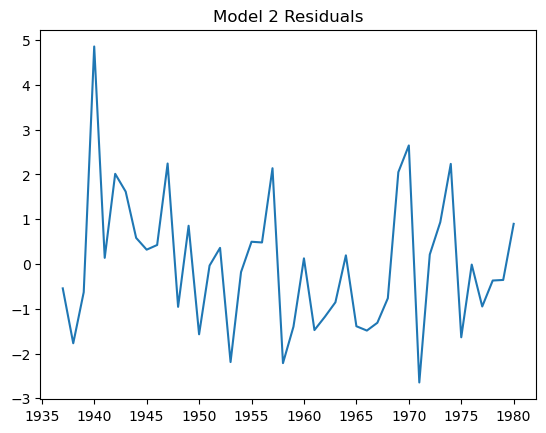

In [13]:
residuals_2 = model_2.resid

plt.plot(residuals_2)
plt.title('Model 2 Residuals')
plt.show()

ACF and PACF graphs for the second model. All of the spikes are within the confidence interval which is similar to the first model.

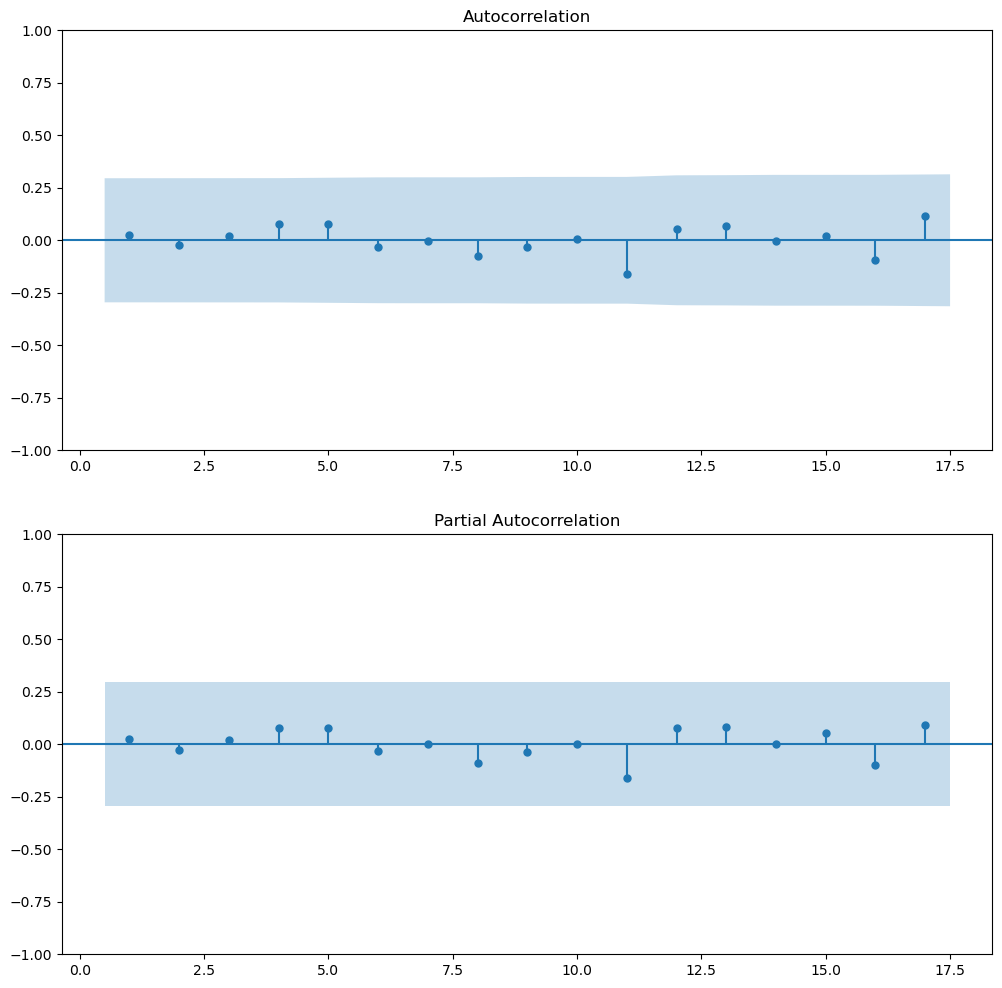

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_2, ax=ax1, zero=False)
plot_pacf(residuals_2, ax=ax2, zero=False)
plt.show()

The residuals for the second model are white noise because the lb_box p-value (0.99) is greater than 0.05.

In [15]:
sm.stats.acorr_ljungbox(residuals_2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,1.13621,0.999692


## Model 1 Error

I am using the predictions to get the errors for each model.

In [16]:
model_1_pred = model_1.get_prediction()

In [17]:
predicted_mean = model_1_pred.predicted_mean
conf_int = model_1_pred.conf_int()

model_1_pred_df = pd.DataFrame({
    'predicted mean': predicted_mean,
    'lower bound': conf_int.iloc[:,0],
    'upper bound': conf_int.iloc[:,1]
})

model_1_pred_df.head()

,predicted mean,lower bound,upper bound
1937-01-01,4.421282,1.041937,7.800627
1938-01-01,4.174680,1.181428,7.167932
1939-01-01,3.487717,0.494465,6.480969
1940-01-01,3.668741,0.675489,6.661993
1941-01-01,6.416592,3.423340,9.409844


In [18]:
model_1_prediction_df = pd.concat([model_1_pred_df, steel_ts.to_frame(name='EXPORT')], axis=1)
model_1_prediction_df.head()

,predicted mean,lower bound,upper bound,EXPORT
1937-01-01,4.421282,1.041937,7.800627,3.89
1938-01-01,4.174680,1.181428,7.167932,2.41
1939-01-01,3.487717,0.494465,6.480969,2.80
1940-01-01,3.668741,0.675489,6.661993,8.72
1941-01-01,6.416592,3.423340,9.409844,7.12


Mean Absolute Percent Error and Root Mean Square Error for Model 1

In [19]:
#errors
errors = model_1_prediction_df['EXPORT'] - model_1_prediction_df['predicted mean']

errors_abs = errors.abs()

mape = ((errors_abs/model_1_prediction_df['EXPORT'].abs()).mean()) * 100

rmse = (errors ** 2).mean()**0.5

print(f'mape % = {mape}')
print(f'rmse = {rmse}')

mape % = 29.548281999954312
rmse = 1.5276441456511083


## Model 2 Error

In [20]:
model_2_pred = model_2.get_prediction()

In [21]:
predicted_mean = model_2_pred.predicted_mean
conf_int = model_2_pred.conf_int()

model_2_pred_df = pd.DataFrame({
    'predicted mean': predicted_mean,
    'lower bound': conf_int.iloc[:,0],
    'upper bound': conf_int.iloc[:,1]
})

model_2_pred_df.head()

,predicted mean,lower bound,upper bound
1937-01-01,4.435149,1.053420,7.816877
1938-01-01,4.180957,1.189353,7.172562
1939-01-01,3.430398,0.473322,6.387474
1940-01-01,3.864007,0.906931,6.821083
1941-01-01,6.983475,4.026398,9.940551


In [22]:
model_2_prediction_df = pd.concat([model_2_pred_df, steel_ts.to_frame(name='EXPORT')], axis=1)
model_2_prediction_df.head()

,predicted mean,lower bound,upper bound,EXPORT
1937-01-01,4.435149,1.053420,7.816877,3.89
1938-01-01,4.180957,1.189353,7.172562,2.41
1939-01-01,3.430398,0.473322,6.387474,2.80
1940-01-01,3.864007,0.906931,6.821083,8.72
1941-01-01,6.983475,4.026398,9.940551,7.12


Mean Absolute Percent Error and Root Mean Square Error for Model 2

In [23]:
errors = model_2_prediction_df['EXPORT'] - model_2_prediction_df['predicted mean']

errors_abs = errors.abs()

mape = ((errors_abs/model_2_prediction_df['EXPORT'].abs()).mean()) * 100

rmse = (errors ** 2).mean()**0.5

print(f'mape % = {mape}')
print(f'rmse = {rmse}')

mape % = 29.279673490437393
rmse = 1.5098150739545273


Forecast Model 1

I chose model 1 because it does not have any significant AR terms. The ACF and PACF residuals are all within the confidence interval, and the residuals are white noise. Even though the second model has a lower MAPE and RMSE, I can sacrifice that for no significant AR terms.

In [24]:
forecast = model_1.get_forecast(steps=3)
mean_forecast_1 = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_df = pd.DataFrame({
    'Forecasted Y': mean_forecast_1,
    'lower bound': confidence_intervals.iloc[:,0],
    'upper bound': confidence_intervals.iloc[:,1]
})

forecast_df

,Forecasted Y,lower bound,upper bound
1981-01-01,4.740960,1.747708,7.734212
1982-01-01,4.569665,1.269683,7.869647
1983-01-01,4.490156,1.127752,7.852560


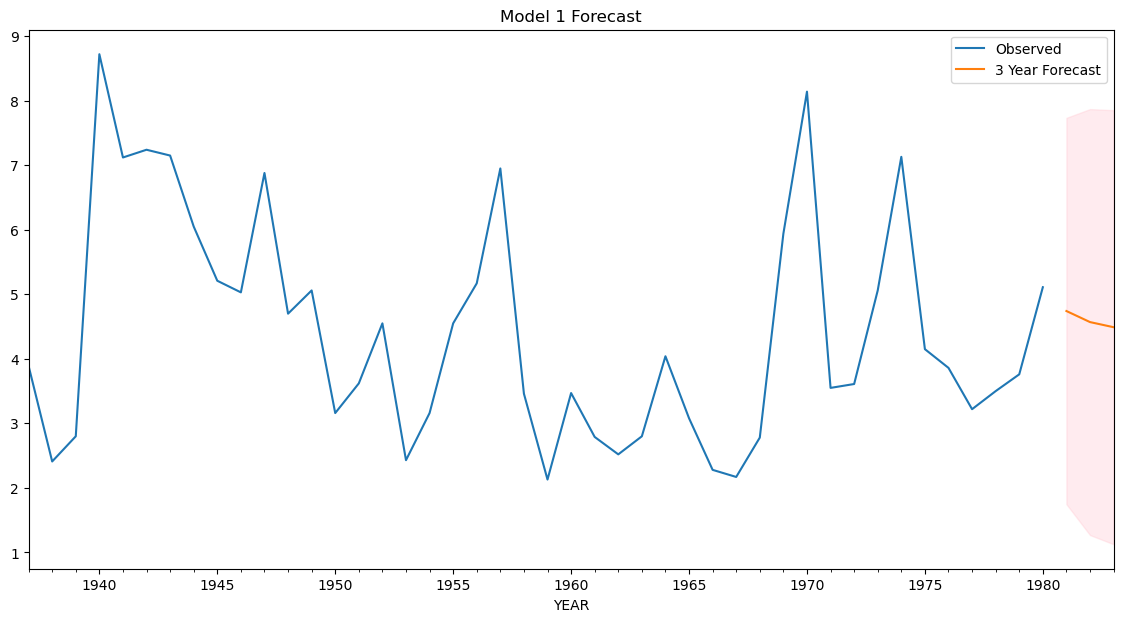

In [25]:
plt.figure(figsize=(14,7))
steel_ts.plot(label='Observed', legend=True)
mean_forecast_1.plot(label='3 Year Forecast', legend=True)
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Model 1 Forecast')
plt.show()